In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F


import snake_game as snake


game = snake.SnakeGame(30,30,1)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Replay buffer

Stores the transitions that the agent observes, allowing us to reuse this data later

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### DQN

In [3]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


### Training

In [4]:
BATCH_SIZE = 128 # Is the number of transitions sampled from the replay buffer
GAMMA = 0.99 # Is the discount factor as mentioned in the previous section
EPS_START = 0.9 # Is the starting value of epsilon
EPS_END = 0.05 # Is the final value of epsilon
EPS_DECAY = 1000 # Controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005 # Is the update rate of the target network
LR = 0.001 # learning rate of the ``AdamW`` optimizer

In [5]:
n_actions = 3  # left, same direction, or right
state, reward, done, score = game.reset()
n_observations = len(state.flatten())  # Flatten the state

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


In [6]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [7]:
episode_scores = []

def plot_scores(show_result=False):
    plt.figure(1)
    scores = [d['score'] for d in episode_scores]
    scores_t = torch.tensor(scores, dtype=torch.float32)
    print(scores)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training ...")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.plot(scores_t.numpy())
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean().view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Train loop to optimize the model

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_next_final_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_next_final_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Train execution

Complete
[3.0, 48.03, 6.0, 2.0, 7.0, 4.0, 9.0, 14.0, 7.0, 13.0, 42.062000000000005, 4.0, 21.038, 25.026, 60.116, 13.02, 27.0, 18.0, 13.0, 33.1, 68.012, 15.0, 20.0, 20.018, 41.0, 10.0, 15.018, 19.0, 19.006, 11.0, 20.0, 26.012, 68.118, 5.0, 6.0, 6.0, 16.0, 27.0, 15.0, 2.0, 7.0, 17.0, 34.018, 3.0, 5.0, 15.006, 35.139999999999986, 8.0, 50.0, 18.0, 33.42400000000001, 9.0, 7.0, 29.129999999999992, 7.0, 37.03, 20.0, 16.0, 30.0, 22.029999999999998, 6.0, 21.006, 14.030000000000001, 8.0, 9.0, 11.0, 18.0, 5.0, 63.06, 34.0, 6.0, 6.0, 5.0, 31.0, 13.0, 9.0, 7.0, 2.0, 10.0, 7.0, 24.058, 16.006, 8.0, 15.0, 27.0, 13.0, 14.0, 13.0, 9.008, 8.0, 9.0, 2.0, 50.106, 11.0, 11.022, 7.0, 8.0, 16.0, 4.0, 25.006, 18.0, 5.0, 33.012, 3.0, 10.0, 33.08, 20.0, 21.028, 5.0, 2.0, 38.106, 13.0, 17.008, 16.0, 7.0, 23.0, 17.012, 7.0, 12.0, 2.0, 14.0, 5.0, 2.0, 12.030000000000001, 10.0, 18.0, 26.012, 3.0, 35.032, 20.028, 23.075999999999997, 13.022, 15.0, 8.0, 3.0, 10.0, 3.0, 8.0, 14.024000000000001, 8.0, 29.012, 7.0, 34.0, 

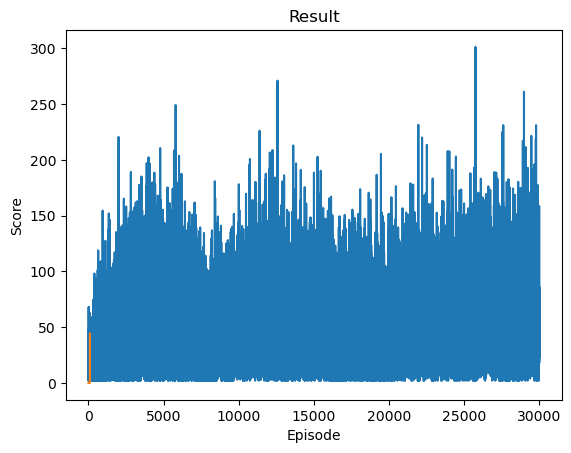

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 30000
else:
    num_episodes = 500

for i_episode in range(num_episodes):
    state, reward, done, score = game.reset()
    state = torch.tensor(state, device=device, dtype=torch.float32).flatten().unsqueeze(0)  # Flatten and unsqueeze the state
    for t in count():
        action = select_action(state)
        next_state, reward, done, score = game.step(action.item() - 1)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(next_state, device=device, dtype=torch.float32).flatten().unsqueeze(0)  # Flatten and unsqueeze the next state

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = TAU * policy_net_state_dict[key] + (1 - TAU) * target_net_state_dict[key]
        if done:
            episode_scores.append(score)
            plot_scores()
            break

print('Complete')
plot_scores(show_result=True)
plt.ioff()
plt.show()
    